# Setup

Change for the Lab

## Setup

In [1817]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Download the Data

In [1818]:
# Download the data 
import os
import tarfile
import urllib.request
import warnings  # Import the warnings module

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


# Definition of how to fetch the data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)

    # Suppress the DeprecationWarning for tarfile extraction
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path, filter=None)
        housing_tgz.close()


In [1819]:
# Execute fetching
fetch_housing_data()

In [1820]:
import pandas as pd

# Definition of how to Load the housing csv from the path
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Create a Test Set

In [1821]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [1822]:
# Create the housing data frame
housing = load_housing_data()

In [1823]:
from sklearn.model_selection import StratifiedShuffleSplit

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [1824]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [1825]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [1826]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

    

# Data cleaning

In [1827]:
from sklearn.impute import SimpleImputer

# Data cleaning 
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]

# Initialize the SimpleImputer for "total_bedrooms" column with the 'median' strategy
imputer = SimpleImputer(strategy="median")

# Fit the imputer on the 'total_bedrooms' column
imputer.fit(housing[["total_bedrooms"]])

# Transform only the 'total_bedrooms' column in sample_incomplete_rows
sample_incomplete_rows["total_bedrooms"] = imputer.transform(sample_incomplete_rows[["total_bedrooms"]])

# Optionally, check the imputation strategy used
print(imputer.strategy)

# Now you can replace the transformed values back into the original dataset
housing.loc[sample_incomplete_rows.index, "total_bedrooms"] = sample_incomplete_rows["total_bedrooms"]

# Final transformed dataset
housing_num = housing.copy()  # or use housing_tr to keep original data intact

housing_num = housing_num.drop("ocean_proximity", axis=1)

housing_num = housing_num.drop("income_cat", axis=1)

median


C:\Users\marco\AppData\Local\Temp\ipykernel_22140\607306170.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_incomplete_rows["total_bedrooms"] = imputer.transform(sample_incomplete_rows[["total_bedrooms"]])


In [1828]:
from sklearn.preprocessing import OneHotEncoder

# Extract the 'ocean_proximity' column
housing_cat = housing[["ocean_proximity"]]

# Initialize the OneHotEncoder with dense output (not sparse)
cat_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the 'ocean_proximity' column
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

# Custom Tranformers

In [1829]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [1830]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

In [1831]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,2,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,5,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,2,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,2,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,3,6.096552,3.167241


## Transformation Pipelines

In [1832]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [1833]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [1834]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [1835]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [1836]:
housing_prepared.shape

(16512, 16)

# Prepare the Data for Machine Learning Algorithms

# Linear Regression

In [1837]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [1838]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(68627.87390018745)

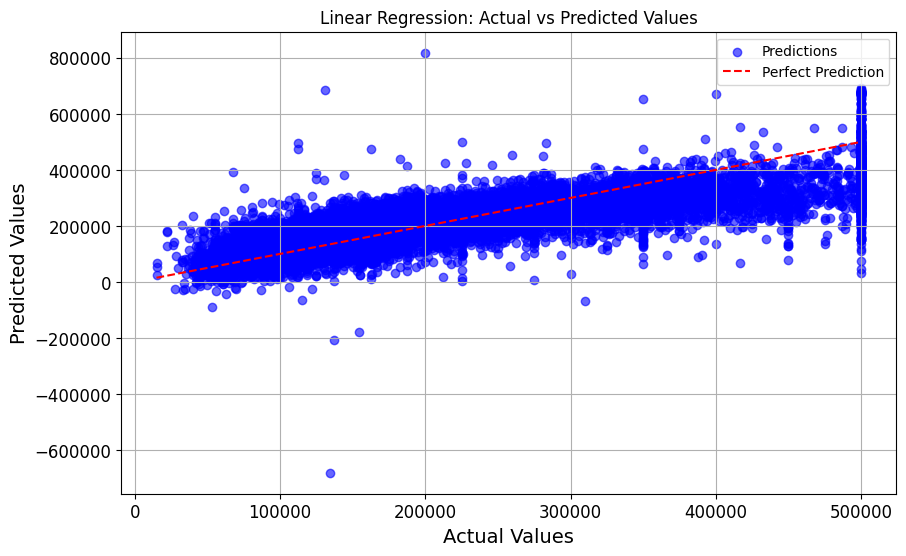

In [1839]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, housing_predictions, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(housing_labels), max(housing_labels)], [min(housing_labels), max(housing_labels)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Descission Tree Regressor

In [1840]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [1841]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

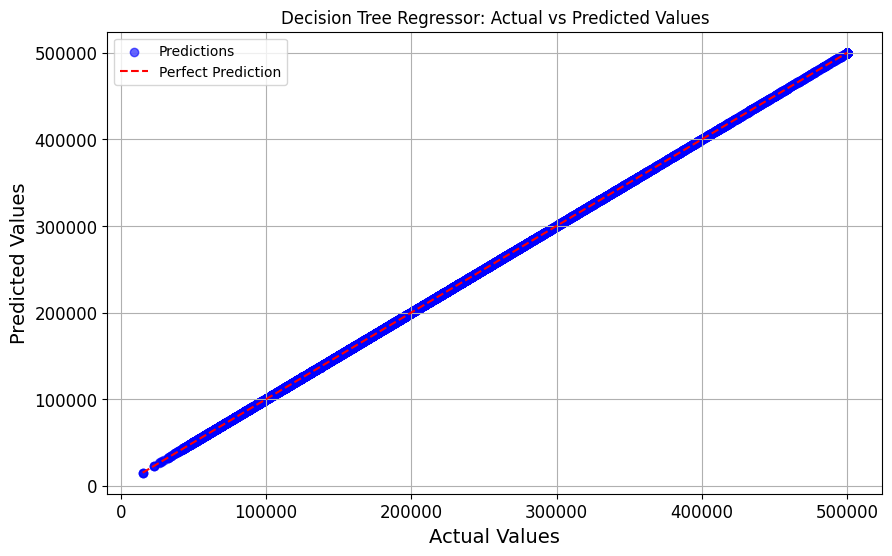

In [1842]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, housing_predictions, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(housing_labels), max(housing_labels)], [min(housing_labels), max(housing_labels)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Decision Tree Regressor: Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Random Forest Regressor 

In [1843]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [1844]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(18650.698705770003)

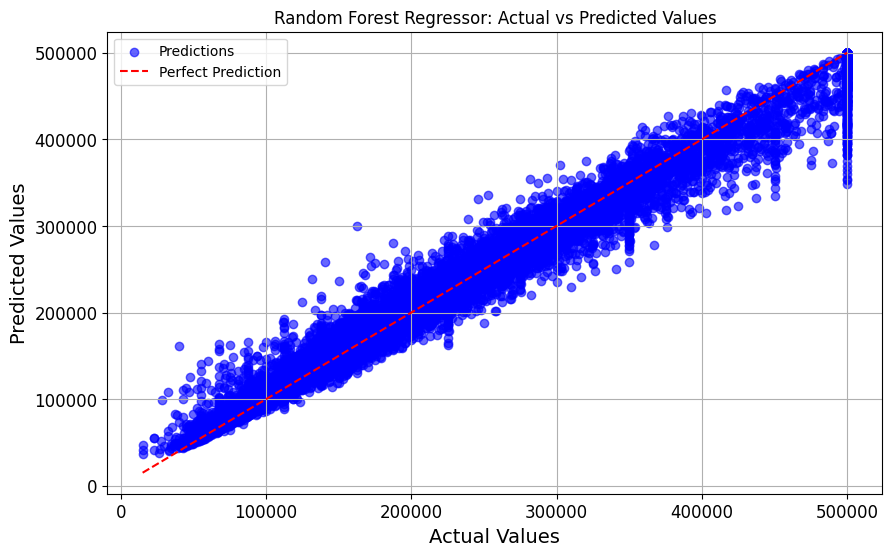

In [1845]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, housing_predictions, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(housing_labels), max(housing_labels)], [min(housing_labels), max(housing_labels)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regressor: Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Support Vector Machine Regressor

In [1846]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

np.float64(111095.06635291968)

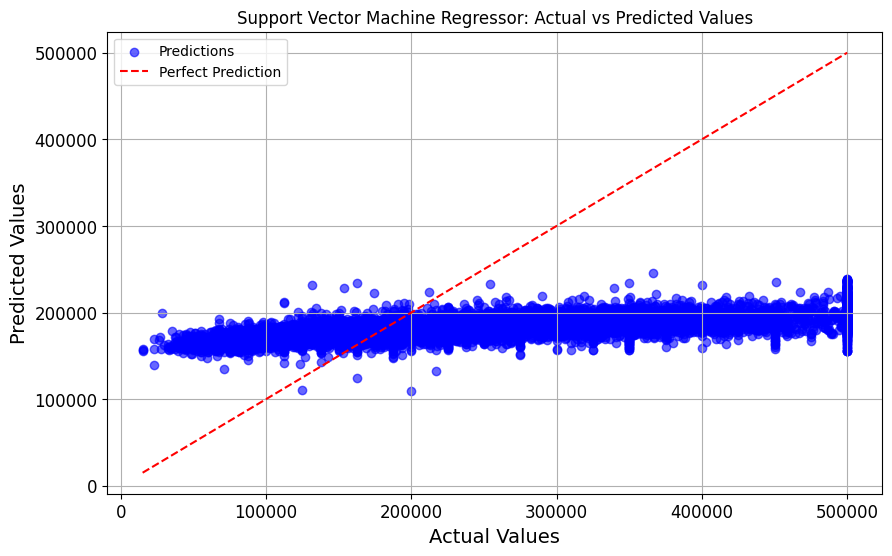

In [1847]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, housing_predictions, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(housing_labels), max(housing_labels)], [min(housing_labels), max(housing_labels)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Support Vector Machine Regressor: Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

## Better Evaluation Using Cross-Validation

In [1848]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [1849]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [1850]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180666


In [1851]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [1852]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69104.079982
std       3036.132517
min      64114.991664
25%      67077.398482
50%      68718.763507
75%      71357.022543
max      73997.080502
dtype: float64

In [1879]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [110518.40356474 112956.5486846  106998.56227015 113590.97575445
 107782.52294955 116063.7781669  113279.08892636 111836.81295967
 113168.96643781 111945.40954593]
Mean: 111814.1069260169
Standard deviation: 2600.8402690892553


IndexError: index 3 is out of bounds for axis 0 with size 3

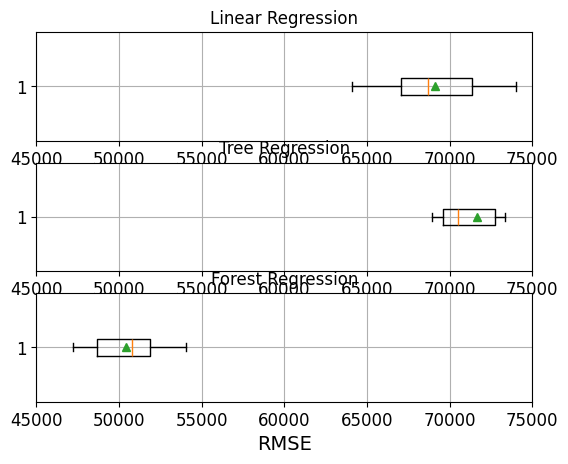

In [1880]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3)  # Create three subplots vertically

# Plot boxplot for linear regression scores in the first subplot
axs[0].boxplot(lin_rmse_scores, vert=False, showmeans=True)
axs[0].set_xlabel("RMSE")
#axs[0].set_ylabel("Cross-Validation Fold (Linear Regression)")
axs[0].set_title("Linear Regression")
axs[0].grid(True)
axs[0].set_xlim(45000, 75000)  # Set x-axis limits

# Plot boxplot for tree regression scores in the second subplot
axs[1].boxplot(tree_rmse_scores, vert=False, showmeans=True)
axs[1].set_xlabel("RMSE")
#axs[1].set_ylabel("Cross-Validation Fold (Tree Regression)")
axs[1].set_title("Tree Regression")
axs[1].grid(True)
axs[1].set_xlim(45000, 75000)  # Set x-axis limits

# Plot boxplot for forest regression scores in the third subplot
axs[2].boxplot(forest_rmse_scores, vert=False, showmeans=True)
axs[2].set_xlabel("RMSE")
#axs[2].set_ylabel("Cross-Validation Fold (Forest Regression)")
axs[2].set_title("Forest Regression")
axs[2].grid(True)
axs[2].set_xlim(45000, 75000)  # Set x-axis limits

# Adjust layout (optional)
plt.tight_layout()  # Adjust spacing between subplots for better readability
plt.show()

## Visuals


In [1874]:
import numpy as np
import matplotlib.pyplot as plt


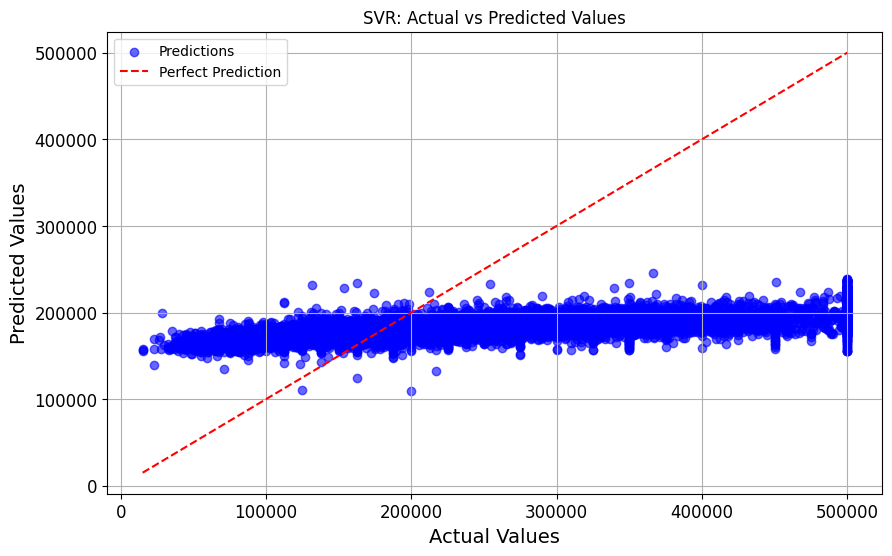

In [1875]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, housing_predictions, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(housing_labels), max(housing_labels)], [min(housing_labels), max(housing_labels)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SVR: Actual vs Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


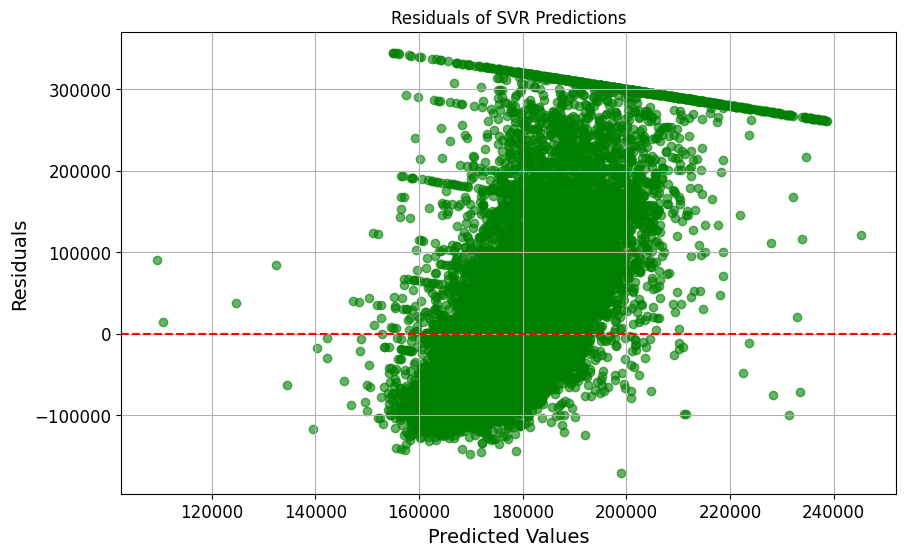

In [1876]:
# Calculate residuals
residuals = housing_labels - housing_predictions

# Create a residual plot
plt.figure(figsize=(10, 6))
plt.scatter(housing_predictions, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals of SVR Predictions")
plt.grid(True)
plt.show()


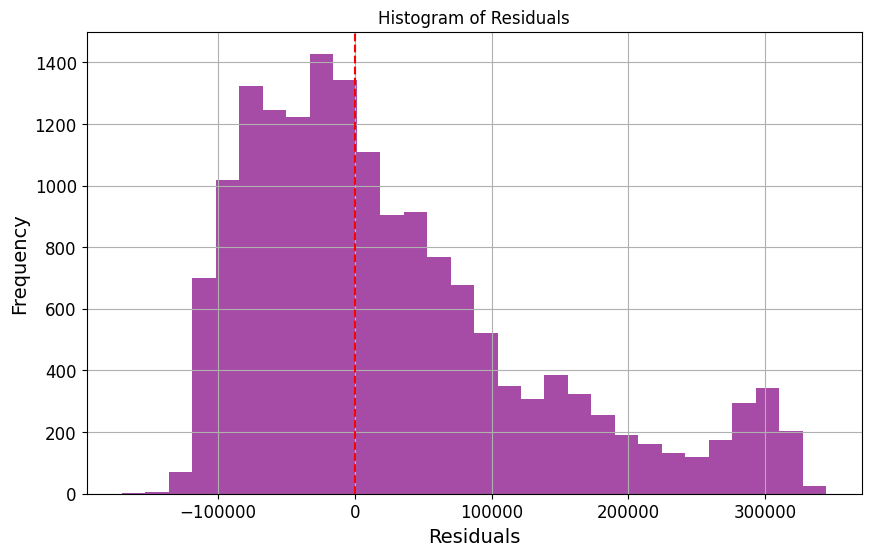

In [1877]:
# Create a histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


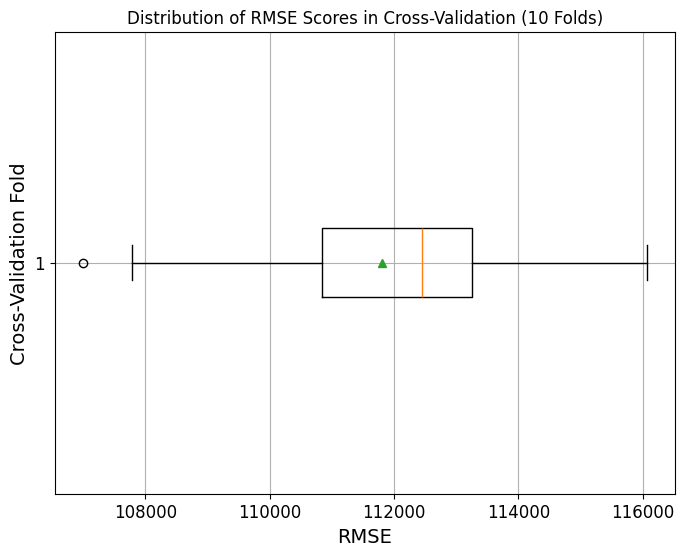

In [1881]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.boxplot(svm_rmse_scores, vert=False, showmeans=True)  # Adjust figsize for aesthetics
plt.xlabel("RMSE")
plt.ylabel("Cross-Validation Fold")
plt.title("Distribution of RMSE Scores in Cross-Validation (10 Folds)")
plt.grid(True)
plt.show()